# Computer Vision: Assignment 3 Part 1 - Some CNN Basics [40%]

Spring 2021 semester.

Due date: **July 19th 2021.**

## Introduction

This question is an introduction to using PyTorch for training simple neural net models. 

Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

Perform this assignment in PyTorch, modifying the baseline code, producing outputs and adding required explanations - *all within this ipython notebook*.

Finally, submit this iPython notebook, including outputs, as an .ipynb file (exact submission guidelines will be given in the next couple of days). 

## Question (1): Warmup [5%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

**a)**  Use `matplotlib` and ipython notebook's visualization capabilities to display one train and one test image of each class, for each of the two datasets.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

** Relevant Cell: "Data Loading" **

## Question (2): Training a Single Layer Network on MNIST [10%]

Start by running the training on MNIST. By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 60,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

**a)** Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

**b)** Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Question (3): Training a Multi-Layer Network on MNIST [10%]

**a)**  Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class] and train the model for 10 epochs.

**b)**   Now set the learning rate to 10 and retrain. Give a brief explanation to the observed results.

## Question (4): Training a Convolutional Network on CIFAR [15%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

**a)** Train it for 20 epochs on the CIFAR-10 training set and Visualize the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist)

**b)**  Give a breakdown of the number of parameters within the above model, as well as the overall number.

# ***Example Code***

In [1]:
# imports
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [35]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [36]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [37]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [38]:
# train and test functions
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [39]:
# Training
for i in range(1, epochs+1):
  train(i)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.452950
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.549214
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.429793
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.385646
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.361336
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.404054
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.287477
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.354044
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.400488
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.332022
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.354786
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.345379
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.308421
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.391875
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.366238
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.272476
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.344385
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.349604
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.275355
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.417278
Train Epoch:

In [40]:
# Testing
test()


Test set: Average loss: 0.2777, Accuracy: 9216/10000 (92%)



# **Answer (1):**


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    if dataset =='mnist':
        img = img*0.3081 + 0.1307 # unnormalize
    elif dataset == 'cifar10':
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

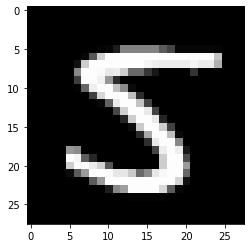

In [14]:
# get some random training images for mnist dataset
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0]))

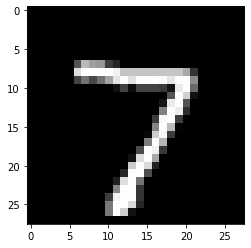

In [15]:
# get some random test images for mnist dataset
dataiter = iter(test_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0]))

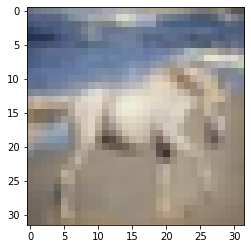

In [19]:
# get some random training images for cifar10 dataset
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0]))

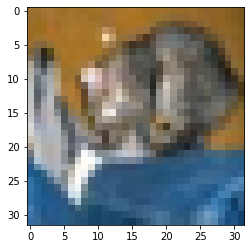

In [20]:
# get some random test images for cifar10 dataset
dataiter = iter(test_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0]))

# **Answer (2):**


## (a)

In [41]:
# plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch.
def plot_network_weights(num_outputs, size):
    for m in network.modules():
        if isinstance(m, nn.Linear):           
            imshow(torchvision.utils.make_grid(m.weight.data.cpu().view(num_outputs,1,size,size),normalize=True, scale_each=True))

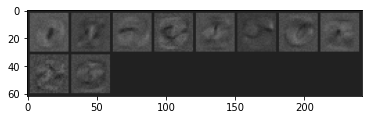

In [42]:
plot_network_weights(10,28)

## (b)

In [43]:
import torch.utils.data.sampler as samplers

class SubsetSampler(samplers.Sampler):
    def __init__(self, data_source, num_samples):
        self.data_source = data_source
        if num_samples < len(self.data_source):
            self.num_samples = num_samples
        else:
            self.num_samples = len(self.data_source)
            
    def __iter__(self):
        return iter(range(self.num_samples))

    def __len__(self):
        return self.num_samples

In [44]:
examples = 50
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, sampler=SubsetSampler(trainset, examples), num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, sampler=SubsetSampler(testset, examples), num_workers=0)

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [45]:
epochs = 70
# Training
for i in range(1, epochs+1):
  train(i)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.356699
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.146133
Train Epoch: 3 [0/60000 (0%)]	Loss: 1.971007
Train Epoch: 4 [0/60000 (0%)]	Loss: 1.821162
Train Epoch: 5 [0/60000 (0%)]	Loss: 1.689263
Train Epoch: 6 [0/60000 (0%)]	Loss: 1.571203
Train Epoch: 7 [0/60000 (0%)]	Loss: 1.464840
Train Epoch: 8 [0/60000 (0%)]	Loss: 1.368827
Train Epoch: 9 [0/60000 (0%)]	Loss: 1.282094
Train Epoch: 10 [0/60000 (0%)]	Loss: 1.203680
Train Epoch: 11 [0/60000 (0%)]	Loss: 1.132695
Train Epoch: 12 [0/60000 (0%)]	Loss: 1.068315
Train Epoch: 13 [0/60000 (0%)]	Loss: 1.009795
Train Epoch: 14 [0/60000 (0%)]	Loss: 0.956465
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.907732
Train Epoch: 16 [0/60000 (0%)]	Loss: 0.863073
Train Epoch: 17 [0/60000 (0%)]	Loss: 0.822031
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.784207
Train Epoch: 19 [0/60000 (0%)]	Loss: 0.749253
Train Epoch: 20 [0/60000 (0%)]	Loss: 0.716867
Train Epoch: 21 [0/60000 (0%)]	Loss: 0.686784
Train Epoch: 22 [0/60000 (0%)]	Loss: 0.6587

In [46]:
# Testing
test()


Test set: Average loss: 0.0056, Accuracy: 31/10000 (0%)



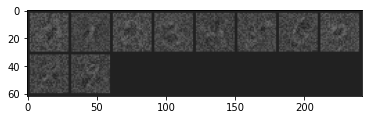

In [47]:
plot_network_weights(10,28)

# **Answer (3):**
create needed blocks of code (and results) below

# **Answer (4):**
create needed blocks of code (and results) below